### 1) Загрузите данные ex4data1.mat из файла.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = '/home/ataleckij/Projects/university/mo/Data/Lab 4/'

In [3]:
files_names = os.listdir(DATA_PATH)
print(files_names)
files_paths = [os.path.join(DATA_PATH, name) for name in files_names]

['ex4data1.mat', 'ex4weights.mat']


In [4]:
from scipy.io import loadmat

data = loadmat(files_paths[0])
weights = loadmat(files_paths[1])

features, labels = data['X'], data['y'].flatten()
print(features.shape, labels.shape)

(5000, 400) (5000,)


### 2) Загрузите веса нейронной сети из файла ex4weights.mat, который содержит две матрицы Θ(1) (25, 401) и Θ(2) (10, 26). Какова структура полученной нейронной сети?

In [5]:
t1, t2 = weights['Theta1'], weights['Theta2']
print(t1.shape, t2.shape)

w1, b1 = t1[:, 1:], t1[:, [0]]
w2, b2 = t2[:, 1:], t2[:, [0]]

(25, 401) (10, 26)


### 3) Реализуйте функцию прямого распространения с сигмоидом в качестве функции активации. 
### 8) Реализуйте функцию вычисления производной для функции активации.
### 9) Инициализируйте веса небольшими случайными числами.
### 10) Реализуйте алгоритм обратного распространения ошибки для данной конфигурации сети.

In [6]:
import numpy as np
import random

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [37]:
class Network:
    def __init__(self, sizes, output=True):
        """
        Список ``sizes`` содержит количество нейронов в соответствующих слоях
        нейронной сети. Смещения и веса для нейронных сетей
        инициализируются случайными значениями, подчиняющимися стандартному нормальному
        распределению. Первый слой подразумевается слоем, принимающим входные данные, 
        поэтому к нему не добавляется смещение
        """

        self.num_layers = len(sizes)
        self.sizes = sizes
#         np.random.seed(42)
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.output = output

    def feedforward(self, a, layer_i=None):
        """
        Вычислить и вернуть выходную активацию нейронной сети
        при получении ``a`` на входе
        """
        for layer_i_, (b, w) in enumerate(zip(self.biases, self.weights)):
            a = sigmoid(np.dot(w, a)+b.T[0])
            if i is not None and layer_i_ == layer_i:
                break
        return a
    
    def predict(self, features):
        return np.asarray([self.feedforward(example_features) 
                           for example_features in features])
    
    def predict_classes(self, features):
        prediction_onehot = self.predict(features)
        return np.argmax(prediction_onehot, axis=1)

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, eta_reduce={}):
        """
        Обучить нейронную сеть, используя алгоритм стохастического
        (mini-batch) градиентного спуска. 
        ``training_data`` - лист кортежей вида ``(x, y)``, где 
        x - вход обучающего примера, y - желаемый выход (в формате one-hot).
        """

        if test_data is not None: n_test = len(test_data)
        n = len(training_data)
        success_tests = 0
        training_data_hoted = [(x[:, np.newaxis], y[:, np.newaxis]) 
                               for x, y in training_data]
        for j in range(epochs):
            if eta_reduce and (j in eta_reduce):
                eta *= eta_reduce[j]
                print(f'new eta: {eta}')
            random.shuffle(training_data_hoted)
            mini_batches = [training_data_hoted[k:k+mini_batch_size]
                            for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if self.output:
                success_trains = self.evaluate(training_data)
                log_message = f'Эпоха {j} \t train: {round(success_trains/n, 4)}'
                if test_data is not None:
                    success_tests = self.evaluate(test_data)
                    test_message = f' \t test: {round(success_tests/n_test, 4)}'
                    log_message += test_message
                print(log_message)
        if test_data is not None:
            return success_tests / n_test

    def update_mini_batch(self, mini_batch, eta):
        """
        Обновить веса и смещения нейронной сети, сделав шаг градиентного
        спуска на основе алгоритма обратного распространения ошибки, примененного
        к одному mini batch.
        ``mini_batch`` - список кортежей вида ``(x, y)``,
        ``eta`` - величина шага (learning rate).
        """
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        eps = eta / len(mini_batch)
        self.weights = [w - eps * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases  = [b - eps * nb for b, nb in zip(self.biases,  nabla_b)]

    def backprop(self, x, y):
        """
        Возвращает кортеж ``(nabla_b, nabla_w)`` - градиент целевой функции по всем параметрам сети.
        ``nabla_b`` и ``nabla_w`` - послойные списки массивов ndarray,
        такие же, как self.biases и self.weights соответственно.
        """

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # прямое распространение (forward pass)

        a, z = [np.array(x).copy()], []
        for b, w in zip(self.biases, self.weights):
            # посчитать активации
            if len(a) > 1:
                zi = np.dot(w, a[-1]) + b#.T[0]
            else:
                zi = np.dot(w, a[-1]) + b#.T[0]
            ai = sigmoid(zi)
            z.append(zi)
            a.append(ai)
        z, a = np.array(z), np.array(a)

        # обратное распространение (backward pass)
        delta = (a[-1] - y)*sigmoid_prime(z[-1])#/(a[-1]*(1-a[-1]))  # ошибка выходного слоя
        nabla_b[-1] = delta # производная J по смещениям выходного слоя
        nabla_w[-1] = np.dot(delta, a[-2].T)  # производная J по весам выходного слоя

        for l in range(2, self.num_layers):
            # дополнительные вычисления, чтобы легче записывалось
            weights = np.array(self.weights).copy()
            delta = np.dot(weights[-(l-1)].T, delta)*sigmoid_prime(z[-l]) # ошибка на слое L-l
            nabla_b[-l] = delta # производная J по смещениям L-l-го слоя
            nabla_w[-l] = np.dot(delta, a[-(l+1)].T) # производная J по весам L-l-го слоя
        return nabla_b, nabla_w

    def evaluate(self, test_data):
        """
        Вернуть количество тестовых примеров, для которых нейронная сеть
        возвращает правильный ответ.
        """
        test_results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """
        Возвращает вектор частных производных целевой функции по активациям выходного слоя.
        """
        return (output_activations-y)

### 4) Вычислите процент правильных классификаций на обучающей выборке. Сравните полученный результат с логистической регрессией.

In [8]:
nn = Network([400, 25, 10])

print([b.shape for b in nn.biases])
print([w.shape for w in nn.weights])

print(b1.shape, b2.shape)
print(w1.shape, w2.shape)

nn.biases = [b1, b2]
nn.weights = [w1, w2]

[(25, 1), (10, 1)]
[(25, 400), (10, 25)]
(25, 1) (10, 1)
(25, 400) (10, 25)


In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels_indexes = le.fit_transform(labels)

predicted_indexes = nn.predict_classes(features)
predicted_labels = le.inverse_transform(predicted_indexes)

(predicted_labels == labels).mean()

0.9752

### 5) Перекодируйте исходные метки классов по схеме one-hot.

In [10]:
labels_onehot = np.zeros((labels.shape[0], labels_indexes.max() + 1))
labels_onehot[np.arange(labels.shape[0]), labels_indexes] = 1

print(labels[:7])
print(labels_onehot[:7])

[10 10 10 10 10 10 10]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### 6) Реализуйте функцию стоимости для данной нейронной сети.
### 7) Добавьте L2-регуляризацию в функцию стоимости.

In [38]:
@np.vectorize
def hack_log(x):
    return np.log(x) if x != 0 else 0

def loss(y_pred, y_true):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    if np.isnan(-(y_true * hack_log(y_pred) + (1-y_true) * hack_log(1-y_pred)).mean()):
        print(y_pred)
        print(y_true)
    return -(y_true * hack_log(y_pred) + (1-y_true) * hack_log(1-y_pred)).mean()


def cost_function_l2(prediction_onehot, y_onehot, b, w, lambda_):
    y_onehot = np.asarray(y_onehot)
    prediction_onehot = np.asarray(prediction_onehot)
    b = np.concatenate([bi.flatten() for bi in b]).flatten()
    w = np.concatenate([wi.flatten() for wi in w]).flatten()
    wb = np.concatenate([w, b]).flatten()
    loss_values = -(y_onehot * hack_log(prediction_onehot) + (1-y_onehot) * hack_log(1-prediction_onehot))
    loss_value = loss_values.sum()
    l2_value = 1/2*lambda_ * (wb ** 2).sum()
    return loss_value / loss_values.shape[0] + l2_value
#     return ((y_onehot - prediction_onehot).sum(axis=1) ** 2).mean() \
#             + 1/2*lambda_ * (wb ** 2).sum()

### 12) Добавьте L2-регуляризацию в процесс вычисления градиентов.

In [39]:
class RegularizedNetwork(Network):
    def __init__(self, sizes, output=True, l2=0, backprop_strategy='analitic'):
        super().__init__(sizes, output)
        self.l2 = l2
        self.backprop_strategy = backprop_strategy
        
    def update_mini_batch(self, mini_batch, eta):
        """
        Обновить веса и смещения нейронной сети, сделав шаг градиентного
        спуска на основе алгоритма обратного распространения ошибки, примененного
        к одному mini batch. Учесть штраф L2.
        ``mini_batch`` - список кортежей вида ``(x, y)``,
        ``eta`` - величина шага (learning rate).
        """
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            if self.backprop_strategy == 'analitic':
                delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            elif self.backprop_strategy == 'numeric':
                delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        eps = eta / len(mini_batch)
        self.weights = [w - eps * nw - self.l2 * w for w, nw in zip(self.weights, nabla_w)]
        self.biases  = [b - eps * nb for b, nb in zip(self.biases,  nabla_b)]
    
    def numerical_backprop(self, x, y, eps=1e-4):
        """
        Возвращает кортеж ``(nabla_b, nabla_w)`` - ЧИСЛЕННЫЙ градиент целевой функции
        по всем параметрам сети. ``nabla_b`` и ``nabla_w`` - послойные списки массивов ndarray,
        такие же, как self.biases и self.weights соответственно.
        """

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
             
        J0 = cost_function_l2(self.predict([x]), [y], self.biases, self.weights, self.l2)
        
        for i in range(len(nabla_b)):
            for j in range(len(nabla_b[i])):
                for k in range(len(nabla_b[i][j])):
                    self.biases[i][j][k] += eps
                    J1 = cost_function_l2(self.predict([x]), [y], self.biases, self.weights, self.l2)
                    self.biases[i][j][k] -= eps
                    nabla_b[i][j][k] = (J1 - J0) / eps
        
        for i in range(len(nabla_w)):
            for j in range(len(nabla_w[i])):
                for k in range(len(nabla_w[i][j])):
                    self.weights[i][j][k] += eps
                    J1 = cost_function_l2(self.predict([x]), [y], self.biases, self.weights, self.l2)
                    self.weights[i][j][k] -= eps
                    nabla_w[i][j][k] = (J1 - J0) / eps
        
        return nabla_b, nabla_w

### 11) Для того, чтобы удостоверится в правильности вычисленных значений градиентов используйте метод проверки градиента с параметром ε = 10-4.

In [13]:
x_, y_ = features[0], labels_onehot[0]
x, y = x_[:, np.newaxis], y_[:, np.newaxis]

nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.0001)

delta_nabla_b, delta_nabla_w = nn_l2.backprop(x, y)
# print(delta_nabla_b[0].shape, delta_nabla_b[1].shape)
# print(delta_nabla_w[0].shape, delta_nabla_w[1].shape)

# nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.0001)
num_delta_nabla_b, num_delta_nabla_w = nn_l2.numerical_backprop(x_, y_, eps=1e-4)

In [14]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

In [15]:
lst = []

for i in range(len(delta_nabla_w)):
    for j in range(len(delta_nabla_w[i])):
        angle = angle_between(delta_nabla_w[i][j], num_delta_nabla_w[i][j])
        lst.append(angle)

np.mean(lst)

51.31754862955253

In [16]:
lst = []

for i in range(len(delta_nabla_b)):
    angle = angle_between(delta_nabla_b[i].T[0], num_delta_nabla_b[i].T[0])
    lst.append(angle)    

np.mean(lst)

41.31244921785192

### 14) Обучите нейронную сеть с использованием градиентного спуска или других более эффективных методов оптимизации.

In [17]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels_onehot, test_labels_onehot = \
    train_test_split(features, labels_onehot, test_size=0.2, stratify=labels, random_state=42)

train_data = list(zip(train_features, train_labels_onehot))
test_data = list(zip(test_features, test_labels_onehot))

In [60]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.0001, backprop_strategy='analitic')
nn_l2.SGD(train_data, eta=0.5, mini_batch_size=32, epochs=10, test_data=test_data)

Эпоха 0 	 train: 0.1985 	 test: 0.204
Эпоха 1 	 train: 0.3167 	 test: 0.328
Эпоха 2 	 train: 0.3713 	 test: 0.381
Эпоха 3 	 train: 0.4193 	 test: 0.419
Эпоха 4 	 train: 0.463 	 test: 0.459
Эпоха 5 	 train: 0.4975 	 test: 0.492
Эпоха 6 	 train: 0.5335 	 test: 0.528
Эпоха 7 	 train: 0.5593 	 test: 0.566
Эпоха 8 	 train: 0.5857 	 test: 0.604
Эпоха 9 	 train: 0.6172 	 test: 0.633


0.633

In [57]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.0001, backprop_strategy='numeric')
nn_l2.SGD(train_data, eta=0.5, mini_batch_size=32, epochs=10, test_data=test_data)

Эпоха 0 	 train: 0.269 	 test: 0.287
Эпоха 1 	 train: 0.3932 	 test: 0.417
Эпоха 2 	 train: 0.4835 	 test: 0.513
Эпоха 3 	 train: 0.554 	 test: 0.56
Эпоха 4 	 train: 0.6135 	 test: 0.635
Эпоха 5 	 train: 0.6747 	 test: 0.672
Эпоха 6 	 train: 0.715 	 test: 0.715
Эпоха 7 	 train: 0.7468 	 test: 0.741
Эпоха 8 	 train: 0.7632 	 test: 0.76
Эпоха 9 	 train: 0.7755 	 test: 0.777


0.777

### 16) Визуализируйте скрытый слой обученной сети.

10


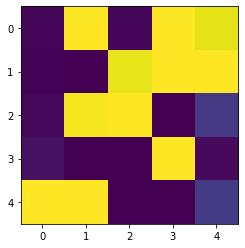

3


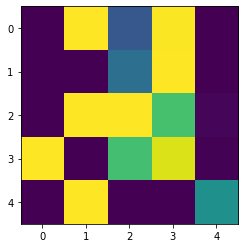

6


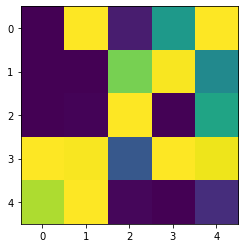

9


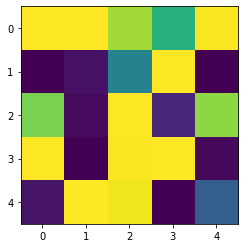

In [61]:
for i in [0, 1500, 3000, 4500]:
    a1 = nn_l2.feedforward(features[i], layer_i=0).reshape((5,5))
    print(labels[i])
    plt.imshow(a1)
    plt.show()

### 15) Вычислите процент правильных классификаций на обучающей выборке.
### 17) Подберите параметр регуляризации. Как меняются изображения на скрытом слое в зависимости от данного параметра?

In [45]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.005, backprop_strategy='analitic')
nn_l2.SGD(train_data, eta=0.5, mini_batch_size=32, epochs=10, test_data=test_data)

Эпоха 0 	 train: 0.224 	 test: 0.222
Эпоха 1 	 train: 0.4022 	 test: 0.391
Эпоха 2 	 train: 0.483 	 test: 0.487
Эпоха 3 	 train: 0.4078 	 test: 0.394
Эпоха 4 	 train: 0.37 	 test: 0.373
Эпоха 5 	 train: 0.2983 	 test: 0.293
Эпоха 6 	 train: 0.2845 	 test: 0.287
Эпоха 7 	 train: 0.295 	 test: 0.299
Эпоха 8 	 train: 0.2575 	 test: 0.257
Эпоха 9 	 train: 0.225 	 test: 0.223


0.223

In [46]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.001, backprop_strategy='analitic')
nn_l2.SGD(train_data, eta=0.5, mini_batch_size=32, epochs=30, test_data=test_data)

Эпоха 0 	 train: 0.2555 	 test: 0.254
Эпоха 1 	 train: 0.3945 	 test: 0.409
Эпоха 2 	 train: 0.5178 	 test: 0.519
Эпоха 3 	 train: 0.6055 	 test: 0.613
Эпоха 4 	 train: 0.6552 	 test: 0.657
Эпоха 5 	 train: 0.7103 	 test: 0.709
Эпоха 6 	 train: 0.7465 	 test: 0.728
Эпоха 7 	 train: 0.7845 	 test: 0.769
Эпоха 8 	 train: 0.8025 	 test: 0.79
Эпоха 9 	 train: 0.8173 	 test: 0.808
Эпоха 10 	 train: 0.8415 	 test: 0.835
Эпоха 11 	 train: 0.8498 	 test: 0.846
Эпоха 12 	 train: 0.8538 	 test: 0.846
Эпоха 13 	 train: 0.8612 	 test: 0.854
Эпоха 14 	 train: 0.864 	 test: 0.857
Эпоха 15 	 train: 0.8705 	 test: 0.862
Эпоха 16 	 train: 0.8752 	 test: 0.863
Эпоха 17 	 train: 0.872 	 test: 0.867
Эпоха 18 	 train: 0.88 	 test: 0.876
Эпоха 19 	 train: 0.8798 	 test: 0.878
Эпоха 20 	 train: 0.8815 	 test: 0.874
Эпоха 21 	 train: 0.8768 	 test: 0.87
Эпоха 22 	 train: 0.8878 	 test: 0.878
Эпоха 23 	 train: 0.8852 	 test: 0.875
Эпоха 24 	 train: 0.8842 	 test: 0.881
Эпоха 25 	 train: 0.8855 	 test: 0.888
Эп

0.886

In [47]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.0011, backprop_strategy='analitic')
nn_l2.SGD(train_data, eta=0.5, mini_batch_size=32, epochs=30, test_data=test_data)

Эпоха 0 	 train: 0.207 	 test: 0.202
Эпоха 1 	 train: 0.3152 	 test: 0.316
Эпоха 2 	 train: 0.408 	 test: 0.415
Эпоха 3 	 train: 0.4948 	 test: 0.508
Эпоха 4 	 train: 0.5925 	 test: 0.604
Эпоха 5 	 train: 0.6655 	 test: 0.666
Эпоха 6 	 train: 0.699 	 test: 0.708
Эпоха 7 	 train: 0.7302 	 test: 0.74
Эпоха 8 	 train: 0.7678 	 test: 0.771
Эпоха 9 	 train: 0.7877 	 test: 0.784
Эпоха 10 	 train: 0.8065 	 test: 0.804
Эпоха 11 	 train: 0.8225 	 test: 0.817
Эпоха 12 	 train: 0.8383 	 test: 0.845
Эпоха 13 	 train: 0.8518 	 test: 0.849
Эпоха 14 	 train: 0.8522 	 test: 0.854
Эпоха 15 	 train: 0.8638 	 test: 0.861
Эпоха 16 	 train: 0.8655 	 test: 0.857
Эпоха 17 	 train: 0.8728 	 test: 0.865
Эпоха 18 	 train: 0.869 	 test: 0.866
Эпоха 19 	 train: 0.876 	 test: 0.875
Эпоха 20 	 train: 0.8782 	 test: 0.875
Эпоха 21 	 train: 0.8735 	 test: 0.872
Эпоха 22 	 train: 0.8728 	 test: 0.87
Эпоха 23 	 train: 0.8788 	 test: 0.876
Эпоха 24 	 train: 0.8812 	 test: 0.883
Эпоха 25 	 train: 0.8835 	 test: 0.871
Эпо

0.884

In [48]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.0009, backprop_strategy='analitic')
nn_l2.SGD(train_data, eta=0.5, mini_batch_size=32, epochs=30, test_data=test_data)

Эпоха 0 	 train: 0.2928 	 test: 0.293
Эпоха 1 	 train: 0.4118 	 test: 0.395
Эпоха 2 	 train: 0.5035 	 test: 0.495
Эпоха 3 	 train: 0.5793 	 test: 0.578
Эпоха 4 	 train: 0.6462 	 test: 0.642
Эпоха 5 	 train: 0.701 	 test: 0.701
Эпоха 6 	 train: 0.743 	 test: 0.745
Эпоха 7 	 train: 0.7622 	 test: 0.753
Эпоха 8 	 train: 0.785 	 test: 0.78
Эпоха 9 	 train: 0.7975 	 test: 0.796
Эпоха 10 	 train: 0.8137 	 test: 0.806
Эпоха 11 	 train: 0.8273 	 test: 0.832
Эпоха 12 	 train: 0.8427 	 test: 0.847
Эпоха 13 	 train: 0.8512 	 test: 0.85
Эпоха 14 	 train: 0.8612 	 test: 0.858
Эпоха 15 	 train: 0.8658 	 test: 0.86
Эпоха 16 	 train: 0.8742 	 test: 0.877
Эпоха 17 	 train: 0.875 	 test: 0.875
Эпоха 18 	 train: 0.876 	 test: 0.875
Эпоха 19 	 train: 0.8788 	 test: 0.875
Эпоха 20 	 train: 0.8818 	 test: 0.887
Эпоха 21 	 train: 0.8825 	 test: 0.88
Эпоха 22 	 train: 0.887 	 test: 0.887
Эпоха 23 	 train: 0.8838 	 test: 0.881
Эпоха 24 	 train: 0.8928 	 test: 0.885
Эпоха 25 	 train: 0.8858 	 test: 0.882
Эпоха 

0.881

In [49]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.000975, backprop_strategy='analitic')
nn_l2.SGD(train_data, eta=0.5, mini_batch_size=32, epochs=30, test_data=test_data)

Эпоха 0 	 train: 0.2427 	 test: 0.239
Эпоха 1 	 train: 0.3483 	 test: 0.348
Эпоха 2 	 train: 0.458 	 test: 0.449
Эпоха 3 	 train: 0.521 	 test: 0.507
Эпоха 4 	 train: 0.584 	 test: 0.579
Эпоха 5 	 train: 0.644 	 test: 0.633
Эпоха 6 	 train: 0.6867 	 test: 0.679
Эпоха 7 	 train: 0.7532 	 test: 0.748
Эпоха 8 	 train: 0.7823 	 test: 0.782
Эпоха 9 	 train: 0.8043 	 test: 0.805
Эпоха 10 	 train: 0.834 	 test: 0.833
Эпоха 11 	 train: 0.838 	 test: 0.838
Эпоха 12 	 train: 0.854 	 test: 0.855
Эпоха 13 	 train: 0.8383 	 test: 0.839
Эпоха 14 	 train: 0.8572 	 test: 0.854
Эпоха 15 	 train: 0.8715 	 test: 0.868
Эпоха 16 	 train: 0.8702 	 test: 0.871
Эпоха 17 	 train: 0.874 	 test: 0.866
Эпоха 18 	 train: 0.8705 	 test: 0.864
Эпоха 19 	 train: 0.8798 	 test: 0.879
Эпоха 20 	 train: 0.8758 	 test: 0.869
Эпоха 21 	 train: 0.8818 	 test: 0.876
Эпоха 22 	 train: 0.878 	 test: 0.868
Эпоха 23 	 train: 0.8805 	 test: 0.873
Эпоха 24 	 train: 0.884 	 test: 0.881
Эпоха 25 	 train: 0.8858 	 test: 0.881
Эпоха 

0.886

In [50]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.0005, backprop_strategy='analitic')
nn_l2.SGD(train_data, eta=0.5, mini_batch_size=32, epochs=30, test_data=test_data)

Эпоха 0 	 train: 0.2265 	 test: 0.224
Эпоха 1 	 train: 0.3135 	 test: 0.315
Эпоха 2 	 train: 0.4015 	 test: 0.4
Эпоха 3 	 train: 0.469 	 test: 0.466
Эпоха 4 	 train: 0.5252 	 test: 0.527
Эпоха 5 	 train: 0.559 	 test: 0.553
Эпоха 6 	 train: 0.6242 	 test: 0.621
Эпоха 7 	 train: 0.6863 	 test: 0.673
Эпоха 8 	 train: 0.7472 	 test: 0.736
Эпоха 9 	 train: 0.767 	 test: 0.76
Эпоха 10 	 train: 0.807 	 test: 0.798
Эпоха 11 	 train: 0.8247 	 test: 0.816
Эпоха 12 	 train: 0.8383 	 test: 0.822
Эпоха 13 	 train: 0.8485 	 test: 0.842
Эпоха 14 	 train: 0.8522 	 test: 0.844
Эпоха 15 	 train: 0.8658 	 test: 0.858
Эпоха 16 	 train: 0.869 	 test: 0.865
Эпоха 17 	 train: 0.8765 	 test: 0.875
Эпоха 18 	 train: 0.8805 	 test: 0.878
Эпоха 19 	 train: 0.8825 	 test: 0.882
Эпоха 20 	 train: 0.8875 	 test: 0.884
Эпоха 21 	 train: 0.885 	 test: 0.883
Эпоха 22 	 train: 0.8905 	 test: 0.888
Эпоха 23 	 train: 0.8915 	 test: 0.883
Эпоха 24 	 train: 0.8975 	 test: 0.899
Эпоха 25 	 train: 0.8968 	 test: 0.894
Эпоха

0.899

In [63]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.00005, backprop_strategy='analitic')
nn_l2.SGD(train_data, eta=0.5, mini_batch_size=32, epochs=30, test_data=test_data)

Эпоха 0 	 train: 0.286 	 test: 0.285
Эпоха 1 	 train: 0.3603 	 test: 0.361
Эпоха 2 	 train: 0.4315 	 test: 0.436
Эпоха 3 	 train: 0.4825 	 test: 0.49
Эпоха 4 	 train: 0.524 	 test: 0.535
Эпоха 5 	 train: 0.561 	 test: 0.577
Эпоха 6 	 train: 0.5958 	 test: 0.608
Эпоха 7 	 train: 0.6355 	 test: 0.634
Эпоха 8 	 train: 0.674 	 test: 0.691
Эпоха 9 	 train: 0.708 	 test: 0.724
Эпоха 10 	 train: 0.7318 	 test: 0.741
Эпоха 11 	 train: 0.7465 	 test: 0.766
Эпоха 12 	 train: 0.7642 	 test: 0.773
Эпоха 13 	 train: 0.7778 	 test: 0.777
Эпоха 14 	 train: 0.7887 	 test: 0.787
Эпоха 15 	 train: 0.7997 	 test: 0.801
Эпоха 16 	 train: 0.813 	 test: 0.805
Эпоха 17 	 train: 0.8187 	 test: 0.822
Эпоха 18 	 train: 0.8273 	 test: 0.824
Эпоха 19 	 train: 0.8313 	 test: 0.833
Эпоха 20 	 train: 0.8343 	 test: 0.828
Эпоха 21 	 train: 0.8415 	 test: 0.837
Эпоха 22 	 train: 0.8435 	 test: 0.839
Эпоха 23 	 train: 0.8498 	 test: 0.84
Эпоха 24 	 train: 0.8518 	 test: 0.844
Эпоха 25 	 train: 0.8562 	 test: 0.844
Эпох

0.856

In [67]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.00001, backprop_strategy='analitic')
nn_l2.SGD(train_data, eta=0.75, mini_batch_size=16, epochs=30, test_data=test_data)

Эпоха 0 	 train: 0.2472 	 test: 0.246
Эпоха 1 	 train: 0.396 	 test: 0.405
Эпоха 2 	 train: 0.5138 	 test: 0.525
Эпоха 3 	 train: 0.6248 	 test: 0.617
Эпоха 4 	 train: 0.6897 	 test: 0.681
Эпоха 5 	 train: 0.76 	 test: 0.758
Эпоха 6 	 train: 0.7947 	 test: 0.781
Эпоха 7 	 train: 0.8227 	 test: 0.805
Эпоха 8 	 train: 0.8335 	 test: 0.816
Эпоха 9 	 train: 0.847 	 test: 0.832
Эпоха 10 	 train: 0.8602 	 test: 0.843
Эпоха 11 	 train: 0.8648 	 test: 0.849
Эпоха 12 	 train: 0.8765 	 test: 0.856
Эпоха 13 	 train: 0.8785 	 test: 0.866
Эпоха 14 	 train: 0.883 	 test: 0.859
Эпоха 15 	 train: 0.8882 	 test: 0.868
Эпоха 16 	 train: 0.892 	 test: 0.868
Эпоха 17 	 train: 0.8928 	 test: 0.876
Эпоха 18 	 train: 0.9005 	 test: 0.881
Эпоха 19 	 train: 0.902 	 test: 0.877
Эпоха 20 	 train: 0.9067 	 test: 0.884
Эпоха 21 	 train: 0.9105 	 test: 0.881
Эпоха 22 	 train: 0.9135 	 test: 0.888
Эпоха 23 	 train: 0.915 	 test: 0.889
Эпоха 24 	 train: 0.9193 	 test: 0.896
Эпоха 25 	 train: 0.919 	 test: 0.896
Эпоха

0.9

In [72]:
nn_l2 = RegularizedNetwork([400, 25, 10], l2=0.00005, backprop_strategy='analitic')
nn_l2.SGD(train_data, eta=5, mini_batch_size=16, epochs=30, test_data=test_data)

Эпоха 0 	 train: 0.8015 	 test: 0.789
Эпоха 1 	 train: 0.872 	 test: 0.853
Эпоха 2 	 train: 0.9062 	 test: 0.893
Эпоха 3 	 train: 0.9167 	 test: 0.9
Эпоха 4 	 train: 0.9305 	 test: 0.921
Эпоха 5 	 train: 0.9305 	 test: 0.91
Эпоха 6 	 train: 0.936 	 test: 0.915
Эпоха 7 	 train: 0.9453 	 test: 0.919
Эпоха 8 	 train: 0.9475 	 test: 0.923
Эпоха 9 	 train: 0.9533 	 test: 0.923
Эпоха 10 	 train: 0.9553 	 test: 0.926
Эпоха 11 	 train: 0.957 	 test: 0.922
Эпоха 12 	 train: 0.959 	 test: 0.922
Эпоха 13 	 train: 0.963 	 test: 0.925
Эпоха 14 	 train: 0.9653 	 test: 0.925
Эпоха 15 	 train: 0.9663 	 test: 0.925
Эпоха 16 	 train: 0.9657 	 test: 0.924
Эпоха 17 	 train: 0.9698 	 test: 0.932
Эпоха 18 	 train: 0.9712 	 test: 0.922
Эпоха 19 	 train: 0.9715 	 test: 0.928
Эпоха 20 	 train: 0.9715 	 test: 0.928
Эпоха 21 	 train: 0.9708 	 test: 0.927
Эпоха 22 	 train: 0.9698 	 test: 0.924
Эпоха 23 	 train: 0.9748 	 test: 0.927
Эпоха 24 	 train: 0.9745 	 test: 0.93
Эпоха 25 	 train: 0.9745 	 test: 0.935
Эпоха

0.931

In [75]:
final_train_data = list(zip(features, labels_onehot))

l2_best = 0.00005
nn_l2 = RegularizedNetwork([400, 25, 10], l2=l2_best, backprop_strategy='analitic')
nn_l2.SGD(final_train_data, eta=10, mini_batch_size=16, epochs=30)

Эпоха 0 	 train: 0.7254
Эпоха 1 	 train: 0.7796
Эпоха 2 	 train: 0.8146
Эпоха 3 	 train: 0.8366
Эпоха 4 	 train: 0.8382
Эпоха 5 	 train: 0.8358
Эпоха 6 	 train: 0.848
Эпоха 7 	 train: 0.8528
Эпоха 8 	 train: 0.8562
Эпоха 9 	 train: 0.8604
Эпоха 10 	 train: 0.8552
Эпоха 11 	 train: 0.8638
Эпоха 12 	 train: 0.868
Эпоха 13 	 train: 0.8684
Эпоха 14 	 train: 0.8704
Эпоха 15 	 train: 0.8684
Эпоха 16 	 train: 0.8688
Эпоха 17 	 train: 0.8692
Эпоха 18 	 train: 0.9668
Эпоха 19 	 train: 0.9728
Эпоха 20 	 train: 0.9738
Эпоха 21 	 train: 0.9744
Эпоха 22 	 train: 0.9728
Эпоха 23 	 train: 0.9764
Эпоха 24 	 train: 0.9664
Эпоха 25 	 train: 0.9586
Эпоха 26 	 train: 0.9782
Эпоха 27 	 train: 0.9792
Эпоха 28 	 train: 0.9792
Эпоха 29 	 train: 0.9786


In [76]:
predicted_indexes = nn_l2.predict_classes(features)
predicted_labels = le.inverse_transform(predicted_indexes)

(predicted_labels == labels).mean()

0.9786

10


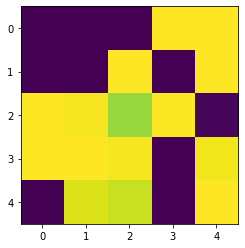

3


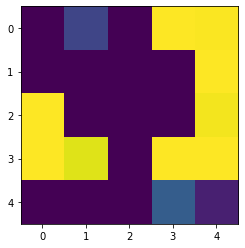

6


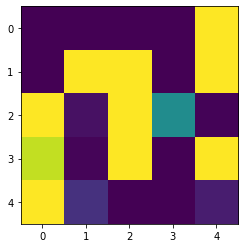

9


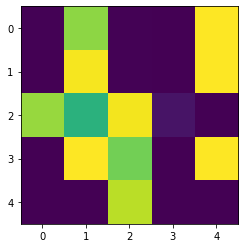

In [77]:
for i in [0, 1500, 3000, 4500]:
    a1 = nn_l2.feedforward(features[i], layer_i=0).reshape((5,5))
    print(labels[i])
    plt.imshow(a1)
    plt.show()